# 2 有信息搜索

搜索时, 可以分析节点, 选择更有可能 / 更容易达到目标节点的节点并扩展.


为此, 可以设计一个启发式损耗函数 (用来估计节点到目标节点的距离), 每次选取启发式函数值最小的节点并扩展.


In [30]:
class Node:
    def __init__(self, name = '', heur = 0):
        self.name = name
        self.children = []    # children pointers
        self.distance = []    # distance to each child
        self.heuristic = heur # heuristic function value
    def __str__(self):
        return self.name
    def AppendChild(self, node, dist = 0):
        self.children.append(node)
        self.distance.append(dist)
    def __lt__(self, node2):
        return self.name < node2.name 
    def __eq__(self, node2):
        return self.name == node2.name
    def __hash__(self):
        return self.name.__hash__()
    def Expand(self):
        pass 
    
def ConstructGraph(edges):
    """Construct an acyclic, directed graph with given edges and node names"""
    nodes = set()
    for edge, dist in edges:
        for name in edge:
            nodes.add(name)
    nodes = dict((name, Node(name)) for name in nodes)
    for edge, dist in edges:
        nodes[edge[0]].AppendChild(nodes[edge[1]], dist)
    return nodes
        
edges = [('sa',1),('ad',3),('dg',2),('ae',8),('ed',1),('ab',1),('bc',1)]
graph = ConstructGraph(edges)
for name, heur in zip('sadegbc',[6,5,2,1,0,6,7]):
    # assign heuristic function values to each node 
    graph[name].heuristic = heur 

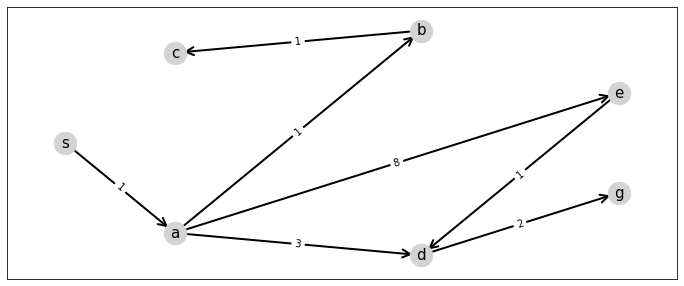

In [31]:
import networkx as nx
from matplotlib import pyplot as plt 

def NXGraph(edges):
    G = nx.DiGraph()
    for nodes, dist in edges:
        G.add_edge(nodes[0], nodes[1], weight = dist)
        
    pos = nx.shell_layout(G) 
    weight = nx.get_edge_attributes(G, "weight")

    nx.draw_networkx_nodes(G, pos, node_size=500, node_color='lightgray')
    nx.draw_networkx_edges(G, pos, width=2, arrowstyle='->', arrowsize=20)
    nx.draw_networkx_labels(G, pos, font_size=15, font_color='black')
    nx.draw_networkx_edge_labels(G, pos, weight)
    plt.show()
    return G 
    
edges = [('sa',1),('ad',3),('dg',2),('ae',8),('ed',1),('ab',1),('bc',1)]
plt.figure(figsize = (12, 5))
NXGraph(edges)

### 贪心搜索

贪心搜索 (Greedy Search): 每次选取启发式函数值最小的节点扩展. 不完备. 且不关心历史损耗.

In [32]:
import heapq
from random import randint 
def Greedy(node: Node, aim = 'g'):
    tree = []
    heuristic, cost, node = node.heuristic, 0, node 
    print('Expand: ')
    while node.name != aim:
        print('%s(Heuristic = %d), '%(node, heuristic), end = '')
        node.Expand()
        for child, dist in zip(node.children, node.distance):
            next_cost = cost + dist
            heapq.heappush(tree, (child.heuristic, next_cost, child))
        heuristic, cost, node = heapq.heappop(tree)

    # print('\nTotal cost = %d'%cost)

Greedy(graph['s'], 'g')

Expand: 
s(Heuristic = 6), a(Heuristic = 5), e(Heuristic = 1), d(Heuristic = 2), 

### ${\rm A}^*$ 搜索

${\rm A}^*$ 搜索设计一个估值函数, 将历史损耗与启发式损耗函数相加. 每次选取新的估值损耗最小的节点扩展.

估值函数 
$$f(x)=g(x)+h(x)$$
其中 $f(x)$ 为估值, $g(x)$ 为历史损耗, $h(x)$ 为启发损耗.

一致代价搜索 UCS 是 $h(x)$ 为常数时的特例.

In [33]:
import heapq
from random import randint 
def Astar(node: Node, aim = 'g', verbose = True):
    tree = []
    evaluation, cost, node = node.heuristic, 0, node 
    if verbose: print('Expand: ')
    while node.name != aim:
        if verbose: print('%s(Evaluate = %d), '%(node, evaluation), end = '')
        node.Expand()
        for child, dist in zip(node.children, node.distance):
            next_cost = cost + dist
            heapq.heappush(tree, (child.heuristic + next_cost, next_cost, child))
        evaluation, cost, node = heapq.heappop(tree)

    # print('\nTotal cost = %d'%cost)

Astar(graph['s'], 'g')

Expand: 
s(Evaluate = 6), a(Evaluate = 6), d(Evaluate = 6), 

## 启发函数的最优性

### 可采纳性

如果对于任一个节点 $n$, 启发函数值 $h(n)$ 非负且不超过真实值 $h^*(n)$ ($h^*(n)$ 表示 $n$ 到目标的最小代价), 则称 $h$ 是可采纳的 (admissible) 启发函数. 

**定理** 使用可采纳的启发函数, 则 ${\rm A}^*$ 搜索有最优性. (即能保证访问目标节点的时候恰是最小代价的路径)

**证明** 设历史价值函数为 $g$, 启发函数为 $h$, 真实最小代价为 $h^*$, 估值函数为 $f=g+h$. 反证法, 假设最小代价到达目标节点的方式为 $S\rightarrow A_1\rightarrow \dotsc \rightarrow A_n$ 并假设算法先发现了 $S\rightarrow B_1\rightarrow \dotsc \rightarrow B_m$. ($A_i,B_j$ 可以相同也可以不同.)

考虑最后一步时, 算法为了访问 $B_m$, 是因为其估值函数 $f(B_m)=g(B_m)+h(B_m)=g(B_m)$ 比其它搜索边缘节点的估值都小.

但是 
$$g(B_m)\geqslant g(A_n) = g(A_i)+h^*(A_i)\geqslant g(A_i)+h(A_i)=f(A_i),\quad \forall i\in\{1,2,\dotsc,n\}$$

即所有 $A_i$ 的估值函数都比 $B_m$ 小, 因此这个时候 $A_1,\dotsc,A_n$ 应该已经被访问到才对. 矛盾.

### 图搜索

很多时候, 不需要重复访问同一个节点. 可以记录已经**访问**的节点, 再次**发现**准备将其插入搜索边缘时跳过. 这就是图搜索.

In [34]:
import heapq
from random import randint 
def GraphAstar(node: Node, aim, verbose = True, show_size = True):
    tree = []
    searched = {}
    evaluation, cost, node, nil = node.heuristic, 0, node, Node('empty')
    pre = nil 
    if verbose: print('Expand: ')
    while node != aim:
        if verbose: print('%s(Evaluate = %d), '%(node, evaluation), end = '')
        if searched.get(node) is None:
            searched[node] = pre 
            node.Expand()
            for child, dist in zip(node.children, node.distance):
                if searched.get(child): # skip this because it has been visited
                    continue 
                next_cost = cost + dist
                heapq.heappush(tree, (child.heuristic + next_cost, next_cost, child, node))
        if len(tree) == 0:
            break 
        evaluation, cost, node, pre = heapq.heappop(tree)

    if show_size: print('Totally expanded %d nodes.'%len(searched))
    if node != aim:
        return None 
    # print('\nTotal cost = %d'%cost)
    sequence = [aim]
    while pre != nil:
        sequence.append(pre)
        pre = searched[pre] 
    return sequence[::-1]

answer = GraphAstar(graph['s'], Node('g'))

Expand: 
s(Evaluate = 6), a(Evaluate = 6), d(Evaluate = 6), Totally expanded 3 nodes.


### 一致性

**定理** 对于 ${\rm A}^*$ 的图搜索版本, 启发函数需要以下两个条件才保证算法的最优性:

* $0\leqslant h(A)\leqslant h^*(A)$
* $h(A)-h(B)\leqslant {\rm cost}(A{\ \rm to\ }B)$

第一个条件即为前文的可采纳性, 第二个则称为一致性 (consistency). 注: 第二个条件蕴含第一个条件中的右边的不等号.

**证明** 不难看出, 第二个条件实际上是说以任何一个点为终点, 都有可采纳性. 即访问每一个点都是通过最小路径访问的. 因此每个节点不需要第二次访问, 符合图搜索的理念.


### 支配性

假设有两个启发函数 $h_1$, $h_2$, 如果对于任意节点 $A$ 都有 $h_1(A)\geqslant h_2(A)$, 就称 $h_1$ 支配 $h_2$. 写作 $h_1\succeq h_2$. 占支配的且可采纳的启发函数一般效果更好 (访问更少节点达到目标).

### 半格

"最小的" 可采纳启发式函数是零函数, 对应 UCS. "最大的" 可采纳启发式函数是真实代价 $h^*$. 两个可采纳的启发函数 $h_1,h_2$ 的最大值 $\max(h_1,h_2)$ 也是可采纳的. 因此启发式函数形成一个[半格](https://encyclopediaofmath.org/wiki/Semi-lattice) (semilattice).

## 例子: 八数码

八数码即华容道游戏. 在 $3\times 3$ 的方阵里有 $1\sim 8$ 与一个空格. 每次可以将空格与一个相邻的数字互换位置. 求解办法到达正确位置. 可以选取可采纳启发函数: 每个数字到正确位置的曼哈顿距离之和.

In [35]:
N = 3
coor = lambda v: (v//N, v%N)
from copy import deepcopy
class GameNode(Node):
    def __init__(self, name='', heur=0):
        super().__init__(name, heur)
        s , t = 0 , N * N 
        for i in range(N):
            for j in range(N):
                s = t * s + self.name[i][j]
        self.hash = s # every STATE can be encoded into a hash value
        
    def Expand(self): 
        """Expand this node -- discovering its neighbors"""
        if len(self.children) > 0:
            return 
        for i in range(N):
            for j in range(N):
                v = self.name[i][j] 
                if v != 0: 
                    x , y = coor(v)
                    self.heuristic += abs(x - i) + abs(y - j) # Manhattan heuristic function
                else:
                    for di, dj in ((-1,0),(1,0),(0,-1),(0,1)): # the neighbors of 0 (empty square)
                        i2 , j2 = i + di , j + dj 
                        if 0 <= i2 < N and 0 <= j2 < N:
                            new_child_name = deepcopy(self.name)
                            new_child_name[i][j] = self.name[i2][j2]
                            new_child_name[i2][j2] = 0
                            self.AppendChild(GameNode(name = new_child_name), 1)
        
    def __lt__(self, node2):
        return self.hash < node2.__hash__()
    def __eq__(self, node2):
        return self.hash == node2.__hash__()
    def __hash__(self):
        return self.hash 

start = [[3,1,2],[4,5,8],[6,7,0]] # easy version (15 nodes)
start = [[7,2,4],[5,0,6],[8,3,1]] # hard version (162240 nodes, run 25 seconds)
end   = [[0,1,2],[3,4,5],[6,7,8]]
answer = GraphAstar(GameNode(start), GameNode(end), verbose = False)

Totally expanded 162240 nodes.


In [36]:
def PrintAnswer(sequence, chunk_size = 14):
    """Print the answer prettily. Feed a new line every ``chunk_size`` moves."""
    for chunk in range(0, len(sequence), chunk_size):
        l = min(chunk_size, len(sequence) - chunk)
        for i in range(N):
            s = ''
            for t in range(chunk, chunk + l):
                s += ' '.join('%d'%sequence[t].name[i][j] for j in range(N))
                s += '    '
            print(s)
        print('')
PrintAnswer(sequence = answer)

7 2 4    7 2 4    0 2 4    2 0 4    2 5 4    2 5 4    2 5 4    2 5 4    2 5 4    2 5 4    2 5 4    2 5 4    2 5 4    2 5 4    
5 0 6    0 5 6    7 5 6    7 5 6    7 0 6    7 6 0    7 6 1    7 6 1    7 6 1    0 6 1    6 0 1    6 1 0    6 1 3    6 1 3    
8 3 1    8 3 1    8 3 1    8 3 1    8 3 1    8 3 1    8 3 0    8 0 3    0 8 3    7 8 3    7 8 3    7 8 3    7 8 0    7 0 8    

2 5 4    2 5 4    2 5 4    2 5 4    2 5 0    2 0 5    0 2 5    1 2 5    1 2 5    1 2 5    1 2 0    1 0 2    0 1 2    
6 1 3    0 1 3    1 0 3    1 3 0    1 3 4    1 3 4    1 3 4    0 3 4    3 0 4    3 4 0    3 4 5    3 4 5    3 4 5    
0 7 8    6 7 8    6 7 8    6 7 8    6 7 8    6 7 8    6 7 8    6 7 8    6 7 8    6 7 8    6 7 8    6 7 8    6 7 8    

